In [21]:
import pandas as pd
import numpy as np
import os


ticker_to_basename = {
    # Indices
    "^NSEI": "NIFTY_50",
    "^NSEBANK": "NIFTY_BANK",
    "^CNXIT": "NIFTY_IT",
    "^CNXPHARMA": "NIFTY_PHARMA",
    "^CNXFMCG": "NIFTY_FMCG",
    "^CNXAUTO": "NIFTY_AUTO",
    "^CNXMETAL": "NIFTY_METAL",
    "^CNXREALTY": "NIFTY_REALTY",
    "^CNXENERGY": "NIFTY_ENERGY",
    "NIFTY_FIN_SERVICE.NS": "NIFTY_FIN_SERVICE",
    
    # Stocks
    "RELIANCE.NS": "RELIANCE_INDUSTRIES_LTD",
    "TCS.NS": "TATA_CONSULTANCY_SERV_LT", # Matched from your image
    "SUNPHARMA.NS": "SUN_PHARMACEUTICAL_IND_L",
    "ICICIBANK.NS": "ICICI_BANK_LTD.",
    "INFY.NS": "INFOSYS_LIMITED",
    "SBIN.NS": "STATE_BANK_OF_INDIA",
    "BHARTIARTL.NS": "BHARTI_AIRTEL_LIMITED",
    "ITC.NS": "ITC_LTD",
    "LT.NS": "LARSEN_&_TOUBRO_LTD.",
    "HINDUNILVR.NS": "HINDUSTAN_UNILEVER_LTD."
}

all_tickers = list(ticker_to_basename.keys())


raw_data_folder = r"X:\AGDrive\ADA-Timeseries project\Raw_Data"
predicted_data_folder = r"X:\AGDrive\ADA-Timeseries project\Pred_Data"
lagging_data_folder = r"X:\AGDrive\ADA-Timeseries project\Lag_Data"

In [22]:
equity_ticker_symbol = "RELIANCE.NS"
equity = "NIFTY_50" 

raw_data_file = os.path.join(raw_data_folder, f"{equity}_data.csv")
predicted_data_file = os.path.join(predicted_data_folder, f"{equity}_predictions_xgboost.csv")
lagging_data_file = os.path.join(lagging_data_folder, f"{equity}_lagged.csv")

raw_data = pd.read_csv(raw_data_file,parse_dates=['Datetime'], index_col='Datetime')
predicted_data = pd.read_csv(predicted_data_file, parse_dates=['Datetime'], index_col='Datetime')
lagging_data = pd.read_csv(lagging_data_file, parse_dates=['Datetime'], index_col='Datetime')

# --- Print to verify ---
print(f"Raw Data File:     {raw_data_file}")
print(f"Predicted File:    {predicted_data_file}")
print(f"Lagging Data File: {lagging_data_file}")

Raw Data File:     X:\AGDrive\ADA-Timeseries project\Raw_Data\NIFTY_50_data.csv
Predicted File:    X:\AGDrive\ADA-Timeseries project\Pred_Data\NIFTY_50_predictions_xgboost.csv
Lagging Data File: X:\AGDrive\ADA-Timeseries project\Lag_Data\NIFTY_50_lagged.csv


In [23]:
from plot_data_util import interactive_data_plot
interactive_data_plot(ticker=equity, data = predicted_data)

In [24]:
interactive_data_plot(ticker=equity, data = predicted_data, n = 50)

In [25]:
from find_missing_predictions_util import find_missing_predictions
missing_rows = find_missing_predictions(predicted_data_file)
print(missing_rows)

No missing 'PredictedPrice' values found in the file.
(0, Empty DataFrame
Columns: []
Index: [])


In [26]:
def simulate_investment(df, amt, start_date, end_date, plot=False):
    df = df.copy()

    if 'Datetime' in df.index.names:
        df = df.reset_index()

    if 'Datetime' not in df.columns:
        raise ValueError("No 'Datetime' column found after reset_index.")

    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").reset_index(drop=True)

    # ---- Filter to start/end range ----
    actual_start = df[df["Datetime"] >= pd.to_datetime(start_date)]
    if actual_start.empty:
        raise ValueError("No data after the given start_date")
    start_row = actual_start.iloc[0]

    actual_end = df[df["Datetime"] <= pd.to_datetime(end_date)]
    if actual_end.empty:
        raise ValueError("No data before the given end_date")
    end_row = actual_end.iloc[-1]

    df = df[(df["Datetime"] >= start_row["Datetime"]) & (df["Datetime"] <= end_row["Datetime"])].reset_index(drop=True)

    # ---- Compute predicted and actual returns ----
    df["pred_return"] = df["PredictedPrice"].pct_change()
    df["actual_return"] = df["ActualPrice"].pct_change()

    invested = False
    cash = amt
    values = [cash]  # track value over time

    for i in range(1, len(df)):
        signal = df.loc[i, "pred_return"]
        actual_r = df.loc[i, "actual_return"]

        # If model predicts profit
        if signal > 0:
            if not invested:
                invested = True
            cash *= (1 + actual_r)
        else:
            if invested:
                invested = False
        values.append(cash)

    df["InvestmentValue"] = values

    final_value = df["InvestmentValue"].iloc[-1]
    profit_pct = ((final_value - amt) / amt) * 100

    summary = {
        "Initial Date Given": start_date,
        "Actual date of investment": str(start_row["Datetime"].date()),
        "Final Date Given": end_date,
        "Actual date of withdraw": str(end_row["Datetime"].date()),
        "Initial Amount": amt,
        "Final Amount": round(final_value, 2),
        "Return (%)": round(profit_pct, 2)
    }

    return summary


In [27]:
actual_returns = {}
expected_returns = {}

start_date = "2025-10-01"
end_date = "2025-11-06"

for ticker, basename in ticker_to_basename.items():
    file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ Missing: {basename}")
        continue

    df = pd.read_csv(file_path, parse_dates=["Datetime"])
    df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

    if len(df) <= 300:
        print(f"⚠️ Skipping {basename} — insufficient valid rows.")
        continue
    df = df.iloc[300:].copy()

    df["Actual_Return"] = df["ActualPrice"].pct_change()
    actual_returns[basename] = df.set_index("Datetime")["Actual_Return"].dropna()

    # Expected return via simulation
    try:
        sim = simulate_investment(df, amt=100000, start_date=start_date, end_date=end_date, plot=False)
        exp_ret = sim["Return (%)"] / 100.0
        expected_returns[basename] = exp_ret
        print(f"{basename}: Expected Return {exp_ret:.3f}")
    except Exception as e:
        print(f"Simulation failed for {basename}: {e}")

# Convert to DataFrames
actual_df = pd.concat(actual_returns, axis=1).dropna()
cov_matrix = actual_df.corr()
expected_return_series = pd.Series(expected_returns)


NIFTY_50: Expected Return 0.038
NIFTY_BANK: Expected Return 0.041
NIFTY_IT: Expected Return 0.057
NIFTY_PHARMA: Expected Return 0.018
NIFTY_FMCG: Expected Return 0.078
NIFTY_AUTO: Expected Return 0.008
NIFTY_METAL: Expected Return 0.051
NIFTY_REALTY: Expected Return 0.045
NIFTY_ENERGY: Expected Return 0.037
NIFTY_FIN_SERVICE: Expected Return 0.046
RELIANCE_INDUSTRIES_LTD: Expected Return 0.067
TATA_CONSULTANCY_SERV_LT: Expected Return 0.027
SUN_PHARMACEUTICAL_IND_L: Expected Return 0.040
ICICI_BANK_LTD.: Expected Return -0.002
INFOSYS_LIMITED: Expected Return 0.076
STATE_BANK_OF_INDIA: Expected Return 0.082
BHARTI_AIRTEL_LIMITED: Expected Return 0.092
ITC_LTD: Expected Return 0.064
LARSEN_&_TOUBRO_LTD.: Expected Return -0.002
HINDUSTAN_UNILEVER_LTD.: Expected Return 0.036


In [28]:
print("\nCovariance Matrix (from Actual Prices):")
cov_matrix.round(6)


Covariance Matrix (from Actual Prices):


,NIFTY_50,NIFTY_BANK,NIFTY_IT,NIFTY_PHARMA,NIFTY_FMCG,NIFTY_AUTO,NIFTY_METAL,NIFTY_REALTY,NIFTY_ENERGY,NIFTY_FIN_SERVICE,RELIANCE_INDUSTRIES_LTD,TATA_CONSULTANCY_SERV_LT,SUN_PHARMACEUTICAL_IND_L,ICICI_BANK_LTD.,INFOSYS_LIMITED,STATE_BANK_OF_INDIA,BHARTI_AIRTEL_LIMITED,ITC_LTD,LARSEN_&_TOUBRO_LTD.,HINDUSTAN_UNILEVER_LTD.
NIFTY_50,1.000000,0.849623,0.616013,0.528665,0.529227,0.764245,0.719705,0.609004,0.785866,0.868798,0.718405,0.517204,0.367868,0.638640,0.531686,0.651852,0.518995,0.443263,0.626593,0.254771
NIFTY_BANK,0.849623,1.000000,0.373609,0.352583,0.312824,0.572459,0.582594,0.547340,0.645071,0.962525,0.530460,0.289608,0.202537,0.762410,0.311167,0.720270,0.367323,0.270009,0.491331,0.105626
NIFTY_IT,0.616013,0.373609,1.000000,0.329025,0.305265,0.421276,0.399448,0.327361,0.365233,0.385176,0.360095,0.835834,0.201717,0.297724,0.881307,0.254642,0.276270,0.247377,0.304286,0.130211
NIFTY_PHARMA,0.528665,0.352583,0.329025,1.000000,0.330274,0.496380,0.502100,0.389806,0.495524,0.359455,0.371528,0.237468,0.754505,0.217715,0.247652,0.297603,0.261049,0.215216,0.324778,0.144862
NIFTY_FMCG,0.529227,0.312824,0.305265,0.330274,1.000000,0.434266,0.280888,0.265782,0.342993,0.342791,0.354848,0.282579,0.243541,0.214373,0.259383,0.219932,0.264729,0.745723,0.208413,0.757211
NIFTY_AUTO,0.764245,0.572459,0.421276,0.496380,0.434266,1.000000,0.631261,0.544443,0.640127,0.574819,0.510640,0.332898,0.307506,0.375572,0.325892,0.472672,0.382571,0.298581,0.437852,0.216969
NIFTY_METAL,0.719705,0.582594,0.399448,0.502100,0.280888,0.631261,1.000000,0.591143,0.768543,0.574128,0.523672,0.279945,0.288347,0.344348,0.301484,0.553215,0.311940,0.221291,0.499253,0.054805
NIFTY_REALTY,0.609004,0.547340,0.327361,0.389806,0.265782,0.544443,0.591143,1.000000,0.636001,0.546784,0.451540,0.224049,0.187296,0.379418,0.218583,0.474299,0.280590,0.202801,0.448630,0.043993
NIFTY_ENERGY,0.785866,0.645071,0.365233,0.495524,0.342993,0.640127,0.768543,0.636001,1.000000,0.627200,0.703362,0.278761,0.292670,0.391557,0.263285,0.664628,0.338262,0.289192,0.608289,0.082980
NIFTY_FIN_SERVICE,0.868798,0.962525,0.385176,0.359455,0.342791,0.574819,0.574128,0.546784,0.627200,1.000000,0.523772,0.304618,0.218724,0.764703,0.323246,0.662905,0.381318,0.291690,0.487741,0.130398


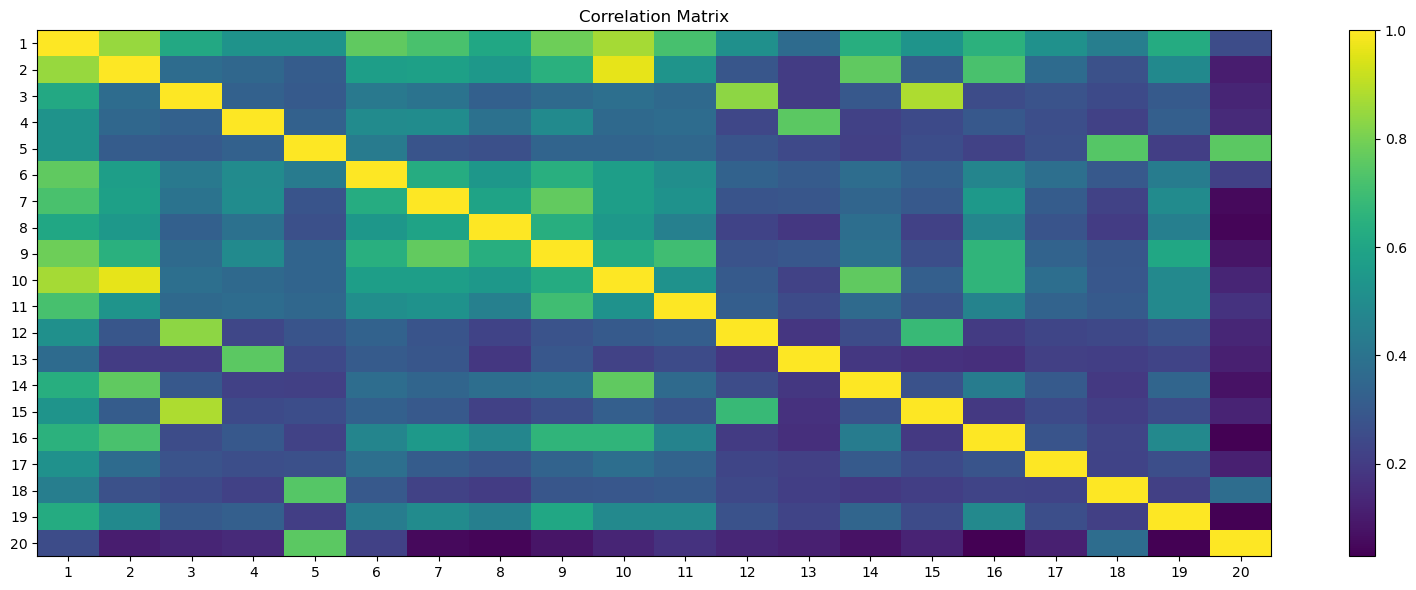

In [29]:
import matplotlib.pyplot as plt

cov_10 = cov_matrix.iloc[:20, :20]

plt.figure(figsize=(16, 6))   # wide rectangle
plt.imshow(cov_10, aspect='auto', interpolation='nearest')
plt.title("Correlation Matrix")
plt.colorbar()

# Use 1 to 20 instead of column names
plt.xticks(range(20), range(1, 21))
plt.yticks(range(20), range(1, 21))

plt.tight_layout()
plt.show()


In [30]:
import pandas as pd
from scipy.stats import shapiro, jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss

results = []

for col in actual_df.columns:
    series = actual_df[col].dropna()

    # --- Normality Tests ---
    try:
        sh_stat, sh_p = shapiro(series)
    except:
        sh_p = None

    jb_stat, jb_p = jarque_bera(series)

    # Normality decision (use Jarque-Bera primarily)
    if jb_p is not None and jb_p > 0.05:
        normality = "Normal"
    else:
        normality = "Not Normal"

    # --- Stationarity Tests ---
    adf_stat, adf_p, _, _, _, _ = adfuller(series, autolag='AIC')
    kpss_stat, kpss_p, _, _ = kpss(series, regression='c')

    # Stationarity decision logic
    if adf_p < 0.05 and kpss_p > 0.05:
        stationarity = "Stationary"
    elif adf_p > 0.05 and kpss_p < 0.05:
        stationarity = "Not Stationary"
    elif adf_p < 0.05 and kpss_p < 0.05:
        stationarity = "Trend Stationary"
    else:
        stationarity = "Inconclusive"

    results.append({
        "Asset": col,
        "Shapiro_p": sh_p,
        "JarqueBera_p": jb_p,
        "Normality": normality,
        "ADF_p": adf_p,
        "KPSS_p": kpss_p,
        "Stationarity": stationarity
    })

# Final summary table
test_results_df = pd.DataFrame(results).set_index("Asset")
test_results_df


C:\Users\ayush\AppData\Local\Temp\ipykernel_19328\1121388453.py:26: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ayush\AppData\Local\Temp\ipykernel_19328\1121388453.py:26: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ayush\AppData\Local\Temp\ipykernel_19328\1121388453.py:26: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ayush\AppData\Local\Temp\ipykernel_19328\1121388453.py:26: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ayush\AppData\Local\Temp\ipykernel_19328\11

,Shapiro_p,JarqueBera_p,Normality,ADF_p,KPSS_p,Stationarity
Asset,,,,,,
NIFTY_50,5.856505e-50,0.0,Not Normal,1.567141e-29,0.1,Stationary
NIFTY_BANK,2.082535e-47,0.0,Not Normal,6.194843e-30,0.1,Stationary
NIFTY_IT,1.509518e-48,0.0,Not Normal,0.000000e+00,0.1,Stationary
NIFTY_PHARMA,3.236078e-47,0.0,Not Normal,0.000000e+00,0.1,Stationary
NIFTY_FMCG,1.962986e-44,0.0,Not Normal,0.000000e+00,0.1,Stationary
NIFTY_AUTO,1.204057e-47,0.0,Not Normal,2.415517e-30,0.1,Stationary
NIFTY_METAL,1.730362e-48,0.0,Not Normal,2.027769e-30,0.1,Stationary
NIFTY_REALTY,7.816379e-44,0.0,Not Normal,5.673702e-30,0.1,Stationary
NIFTY_ENERGY,1.119588e-52,0.0,Not Normal,7.476156e-30,0.1,Stationary


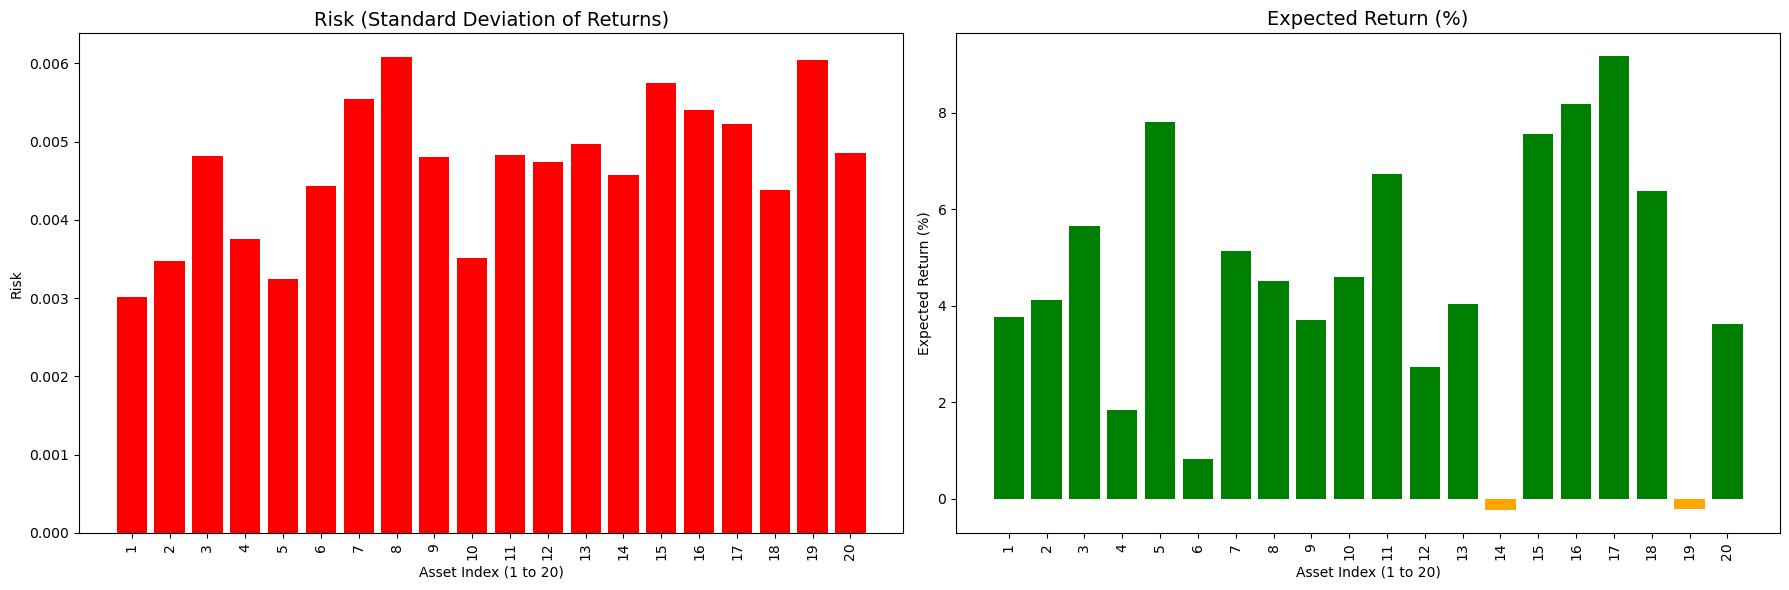

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# --- RISK (std dev of RETURNS) ---
risk_series = actual_df.std()

# --- EXPECTED RETURN (%) ---
exp_return = expected_return_series * 100   # convert decimals to %

# --- Color map for returns ---
return_colors = ['green' if val >= 0 else 'orange' for val in exp_return]

# --- PLOT ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- LEFT: RISK (RED) ---
axes[0].bar(range(len(risk_series)), risk_series, color='red')
axes[0].set_title("Risk (Standard Deviation of Returns)", fontsize=14)
axes[0].set_xlabel("Asset Index (1 to 20)")
axes[0].set_ylabel("Risk")
axes[0].set_xticks(range(len(risk_series)))
axes[0].set_xticklabels(range(1, len(risk_series) + 1), rotation=90)

# --- RIGHT: EXPECTED RETURN (GREEN for +ve, ORANGE for -ve) ---
axes[1].bar(range(len(exp_return)), exp_return, color=return_colors)
axes[1].set_title("Expected Return (%)", fontsize=14)
axes[1].set_xlabel("Asset Index (1 to 20)")
axes[1].set_ylabel("Expected Return (%)")
axes[1].set_xticks(range(len(exp_return)))
axes[1].set_xticklabels(range(1, len(exp_return) + 1), rotation=90)

plt.tight_layout()
plt.show()


In [32]:
stocks = [
    "RELIANCE_INDUSTRIES_LTD",
    "SUN_PHARMACEUTICAL_IND_L",
    "HINDUSTAN_UNILEVER_LTD.",
    
]
indices = [
    "NIFTY_50",
    "NIFTY_BANK",
    "NIFTY_IT"
]

selected_assets = indices + stocks   # total 6
price_data = {}

for asset in selected_assets:
    basename = asset
    file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")

    if not os.path.exists(file_path):
        print("Missing:", file_path)
        continue

    df = pd.read_csv(file_path, parse_dates=["Datetime"])
    df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice"])
    df = df.iloc[300:]    # same as your returns cleaning

    price_data[asset] = df.set_index("Datetime")["ActualPrice"]



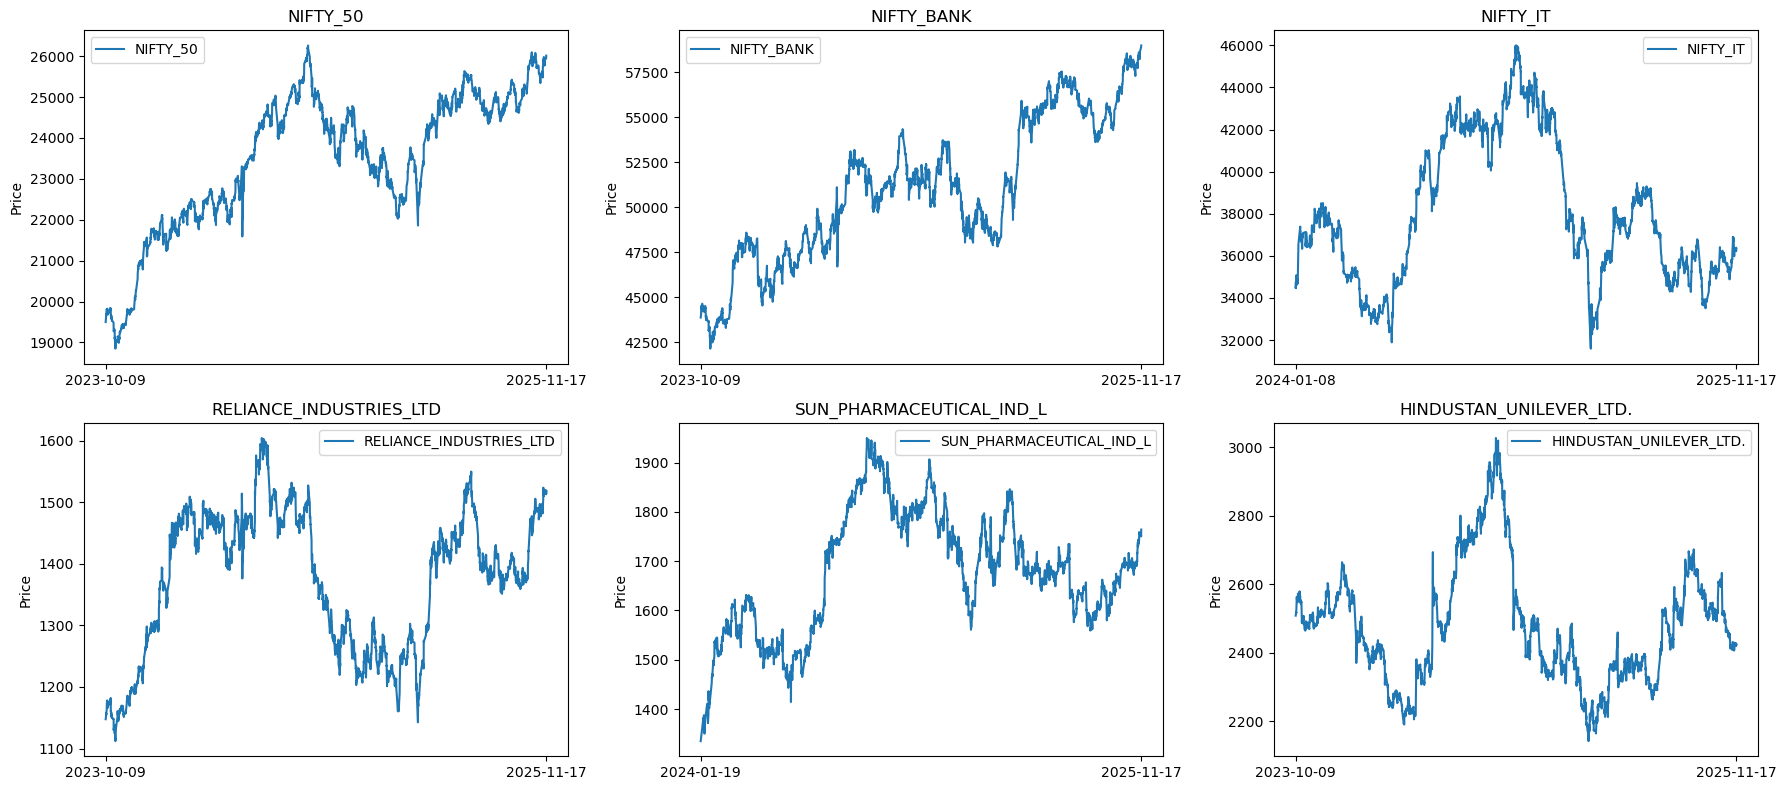

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, asset in enumerate(selected_assets):
    if asset not in price_data:
        continue
    
    price = price_data[asset]

    axes[i].plot(price, label=asset)
    axes[i].set_title(asset)
    axes[i].set_ylabel("Price")
    axes[i].legend()

    # --- SHOW ONLY START AND END DATE ---
    axes[i].set_xticks([price.index[0], price.index[-1]])
    axes[i].set_xticklabels([price.index[0].date(), price.index[-1].date()])
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

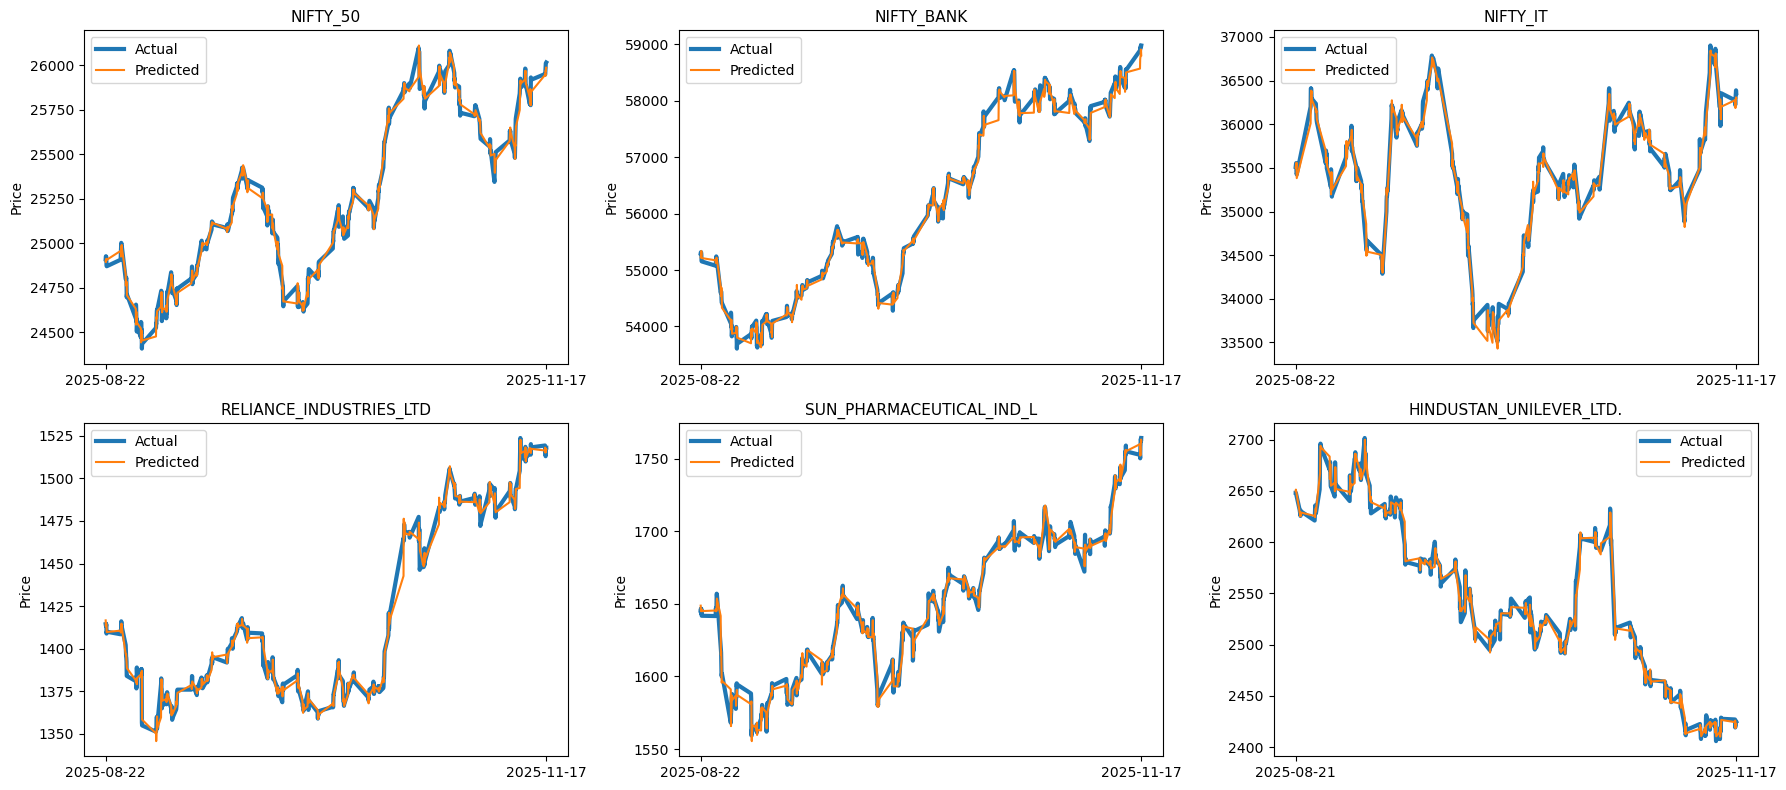

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, asset in enumerate(selected_assets):
    if asset not in price_data:
        continue
    
    # Read file again (we now need predicted price too)
    file_path = os.path.join(predicted_data_folder, f"{asset}_predictions_xgboost.csv")
    df = pd.read_csv(file_path, parse_dates=["Datetime"])
    df = df.tail(700)
    df = df.replace([-np.inf, np.inf], np.nan)
    df = df.iloc[300:]   # skip first 300 rows of lag-induced NaN
    df = df.dropna(subset=["ActualPrice", "PredictedPrice"])

    df = df.set_index("Datetime")

    actual = df["ActualPrice"]
    pred   = df["PredictedPrice"]

    # ---- Plot Actual and Predicted ----
    axes[i].plot(actual, label="Actual", linewidth=3)
    axes[i].plot(pred, label="Predicted", linestyle="-")

    axes[i].set_title(asset, fontsize=11)
    axes[i].set_ylabel("Price")
    axes[i].legend()

    # show only start and end date on x-axis
    axes[i].set_xticks([df.index[0], df.index[-1]])
    axes[i].set_xticklabels([df.index[0].date(), df.index[-1].date()])
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [37]:
import os
import numpy as np
import pandas as pd

results = []

for ticker, basename in ticker_to_basename.items():
    file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")

    if not os.path.exists(file_path):
        print(f"Missing: {basename}")
        continue

    # Read and clean
    df = pd.read_csv(file_path, parse_dates=["Datetime"])
    df = df.replace([-np.inf, np.inf], np.nan)
    df = df.iloc[300:]                       # skip first 300 rows
    df = df.dropna(subset=["ActualPrice", "PredictedPrice"])

    if df.empty:
        continue

    actual = df["ActualPrice"].values
    pred   = df["PredictedPrice"].values

    # --- Compute Errors ---
    mse_pct = np.mean(((pred - actual) / actual) ** 2) * 100       # MSE in %
    mape    = np.mean(np.abs((actual - pred) / actual)) * 100       # MAPE %

    results.append([basename, mse_pct, mape])


# Convert to DataFrame
res_df = pd.DataFrame(results, columns=["Asset", "MSE (%)", "MAPE (%)"])

# Sort alphabetically (optional, clearer presentation)
res_df = res_df.sort_values("Asset").reset_index(drop=True)

# Print
print("\n=== Model Error Summary (MSE% and MAPE) ===")
print(res_df.to_string(index=False))


# ---------- Display in 2 ROWS as you requested ----------
print("\n=== Row 1 (First 10 Assets) ===")
print(res_df.iloc[:10].to_string(index=False))

print("\n=== Row 2 (Remaining Assets) ===")
print(res_df.iloc[10:].to_string(index=False))



=== Model Error Summary (MSE% and MAPE) ===
                   Asset  MSE (%)  MAPE (%)
   BHARTI_AIRTEL_LIMITED 0.002565  0.349290
 HINDUSTAN_UNILEVER_LTD. 0.001542  0.272366
         ICICI_BANK_LTD. 0.001721  0.294943
         INFOSYS_LIMITED 0.001863  0.306504
                 ITC_LTD 0.001713  0.283601
    LARSEN_&_TOUBRO_LTD. 0.002625  0.329475
                NIFTY_50 0.000721  0.180100
              NIFTY_AUTO 0.001488  0.269196
              NIFTY_BANK 0.001007  0.216410
            NIFTY_ENERGY 0.001947  0.284704
       NIFTY_FIN_SERVICE 0.001057  0.217263
              NIFTY_FMCG 0.000844  0.200900
                NIFTY_IT 0.001452  0.270334
             NIFTY_METAL 0.002253  0.328589
            NIFTY_PHARMA 0.000964  0.220761
            NIFTY_REALTY 0.002905  0.375494
 RELIANCE_INDUSTRIES_LTD 0.001721  0.288065
     STATE_BANK_OF_INDIA 0.002737  0.344632
SUN_PHARMACEUTICAL_IND_L 0.001946  0.312451
TATA_CONSULTANCY_SERV_LT 0.002017  0.301597

=== Row 1 (First 10 Assets) ==

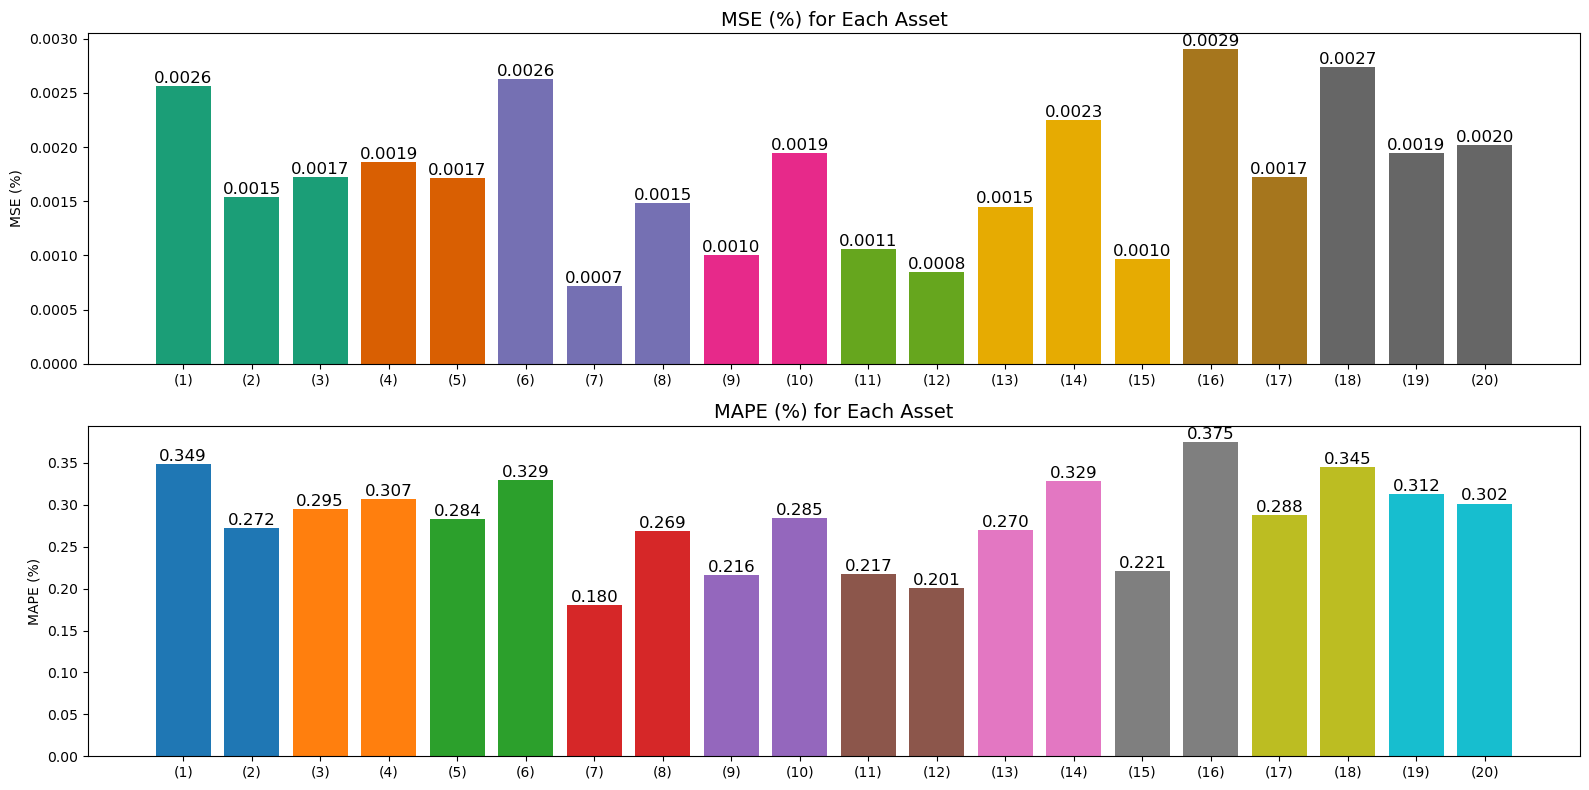

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data
assets = res_df["Asset"].values
mse_vals = res_df["MSE (%)"].values
mape_vals = res_df["MAPE (%)"].values

# Replace names with (1), (2), ..., (n)
labels = [f"({i+1})" for i in range(len(assets))]

# Darker colormaps
colors_mse  = plt.cm.Dark2(np.linspace(0, 1, len(assets)))
colors_mape = plt.cm.tab10(np.linspace(0, 1, len(assets)))

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# ------------------ MSE PLOT ------------------
axes[0].bar(labels, mse_vals, color=colors_mse)
axes[0].set_title("MSE (%) for Each Asset", fontsize=14)
axes[0].set_ylabel("MSE (%)")
axes[0].tick_params(axis='x', rotation=0)

# Add value labels
for x, y in zip(labels, mse_vals):
    axes[0].text(
        x, 
        y + (max(mse_vals) * 0.00005), 
        f"{y:.4f}", 
        ha='center', 
        va='bottom', 
        fontsize=12,
        color='black'
    )

# ------------------ MAPE PLOT ------------------
axes[1].bar(labels, mape_vals, color=colors_mape)
axes[1].set_title("MAPE (%) for Each Asset", fontsize=14)
axes[1].set_ylabel("MAPE (%)")
axes[1].tick_params(axis='x', rotation=0)

# Add value labels
for x, y in zip(labels, mape_vals):
    axes[1].text(
        x, 
        y + (max(mape_vals) * 0.00005), 
        f"{y:.3f}", 
        ha='center', 
        va='bottom', 
        fontsize=12,
        color='black'
    )

plt.tight_layout()
plt.show()
